In [1]:
import os
import sys

# Importante, serve a fare in modo che il jupyter notebook possa vedere ed importare i file di libreria che creiamo in questa cartella.
sys.path.insert(0, os.getcwd())

In [2]:
# Importiamo le librerie che ci servono
from sklearn.linear_model import Ridge
from functions.evaluation import Evaluator, EvaluationResult
from functions.features import add_median_price
from functions.load import loadBestParameterModel
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt

In [3]:
#Funzione per estrarre solo alcune features dal dataset grezzo
def load_features(features: list):
  from functions.load import loadDataFrame
  _df = loadDataFrame('./data/raw.arff')
  outliers = _df[(_df['Gr_Liv_Area'] > 4000) & (_df['Sale_Price'] < 200000)].index
  _df.drop(outliers, inplace = True)

  return [_df[f] for f in features]

In [4]:
# Carichiamo il dataset dal file csv
df = read_csv('./data/ridge_features_refined_data.csv')
#otteniamo le features che ci servono
lat, lon, sp = load_features(['Latitude', 'Longitude', 'Sale_Price'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lot_Area,2927.0,7.476842e-16,1.000171,-3.775920,-0.346207,0.120200,0.514420,6.272148
Overall_Qual,2927.0,6.090878e+00,1.406195,1.000000,5.000000,6.000000,7.000000,10.000000
Overall_Cond,2927.0,5.563717e+00,1.111960,1.000000,5.000000,5.000000,6.000000,9.000000
Mas_Vnr_Area,2927.0,0.000000e+00,1.000171,-0.790677,-0.790677,-0.790677,1.156440,2.029755
Exter_Qual,2927.0,2.396994e+00,0.578344,1.000000,2.000000,2.000000,3.000000,4.000000
...,...,...,...,...,...,...,...,...
Garage_Type_No_Garage,2927.0,5.363854e-02,0.225342,0.000000,0.000000,0.000000,0.000000,1.000000
Sale_Type_'WD ',2927.0,8.664161e-01,0.340263,0.000000,1.000000,1.000000,1.000000,1.000000
Year_Sold,2927.0,2.007791e+03,1.317120,2006.000000,2007.000000,2008.000000,2009.000000,2010.000000
Mo_Sold,2927.0,6.215237e+00,2.712368,1.000000,4.000000,6.000000,8.000000,12.000000


Diamo un occhiata alla forma originale dei quartieri nella città di Ames, secondo i dati raccolti dal dataset.

In [5]:
#Funzione per plottare le varie zone con i prezzi delle case e i cluster di quartieri fatti da noi
def plot_houses(df):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7))
  acm = plt.cm.inferno
  bcm = plt.cm.tab20

  a1.set_title('Sale Price')
  a1.set_xlabel('Latitude')
  a1.set_ylabel('Longitude')
  fig.colorbar(a1.scatter(lon, lat, c=sp, cmap=acm, marker='x', alpha=0.5), ax=a1)

  a2.scatter(lon, lat, c=df['Neighborhood'], cmap=bcm, marker='x', alpha=0.75)
  a2.set_title('Neighborhood')
  a2.set_xlabel('Latitude')
  a2.set_ylabel('Longitude')

  return plt.show()

In [6]:
RANDOM_STATE  = 42
NEIGHBORHOODS = 28

#Eseguiamo il ridge regressor con i parametri ottimizzati(è uno dei modelli migliori)
p = loadBestParameterModel('Ridge')
model = Ridge(**p, random_state=RANDOM_STATE)
ev = Evaluator(model, df, 'Sale_Price')
ev.evaluate()

r2:                  0.89861
explained_variance:  0.89861
rmse:                0.32180
mae:                 0.15604
max_error:           3.85431

### Creazione dei quartieri tramite metodi di clustering

Possiamo ora ignorare i dati effettivi sui quartieri di Ames e ricostruire i quartieri usando i dati reperiti direttamente dalla posizione geografica di ogni casa.

Useremo i seguenti metodi:
 - K-means
 - DBSCAN
 - Mean-shift
 - Agglomerative clustering
 - Affinity propagation

#### K-means

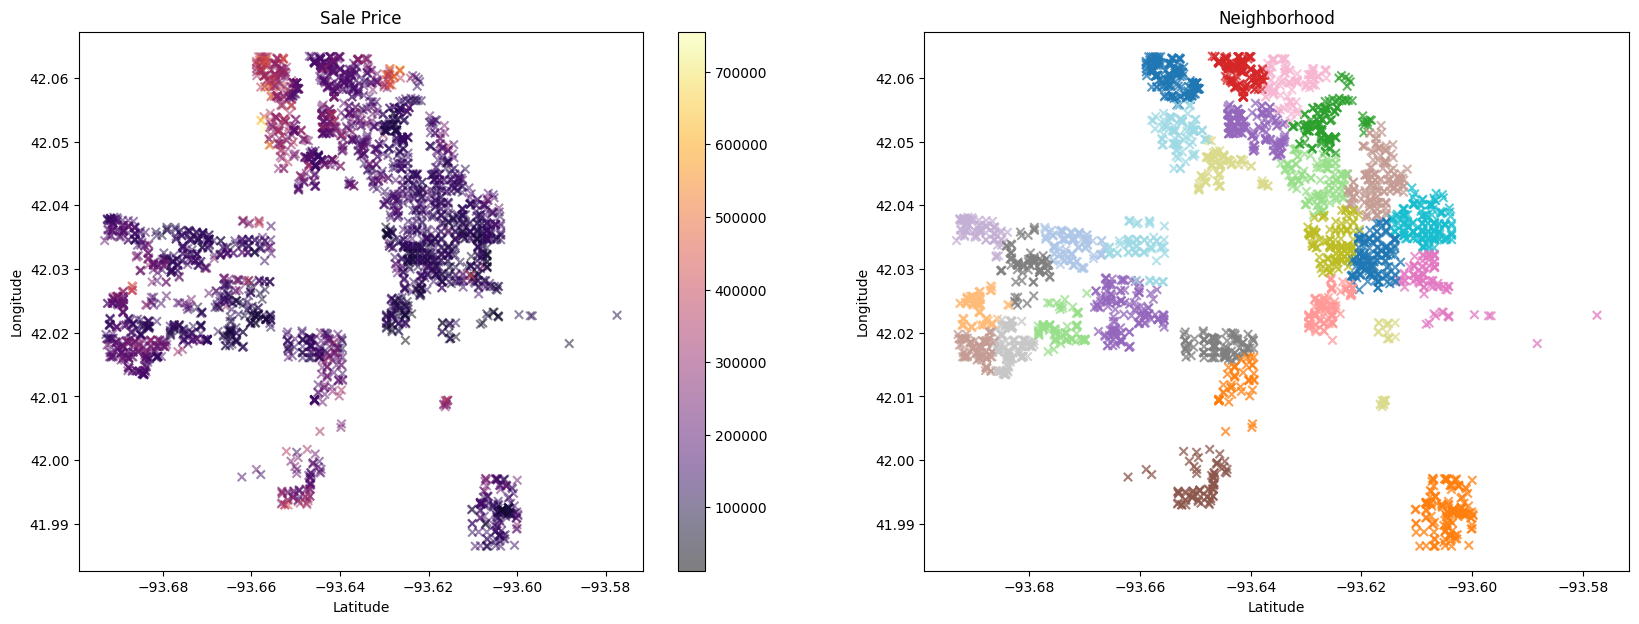

In [7]:
# KMeans
from sklearn.cluster import KMeans

df_km = df.copy()

kmeans = KMeans(n_clusters=NEIGHBORHOODS, n_init=10).fit(DataFrame([lat, lon]).T)
df_km['Neighborhood'] = kmeans.labels_
plot_houses(df_km)


In [8]:
#aggiungiamo la mediana dei prezzi delle case vendute in quel quartiere prima della vendita della nuova casa
df_km = add_median_price(df_km)
#Eseguiamo il ridge regressor ma ora con la nuova feature
km_ev = Evaluator(model, df_km, 'Sale_Price')

#Valutiamo il modello
km_ev.evaluate()

r2:                  0.89832
explained_variance:  0.89838
rmse:                0.32399
mae:                 0.15892
max_error:           3.83163

##### Analisi dei risultati

Come si puo notare, la valutazione del modello e' leggermente inferiore rispetto a quella ottenuta con i dati originali. 

#### DBSCAN

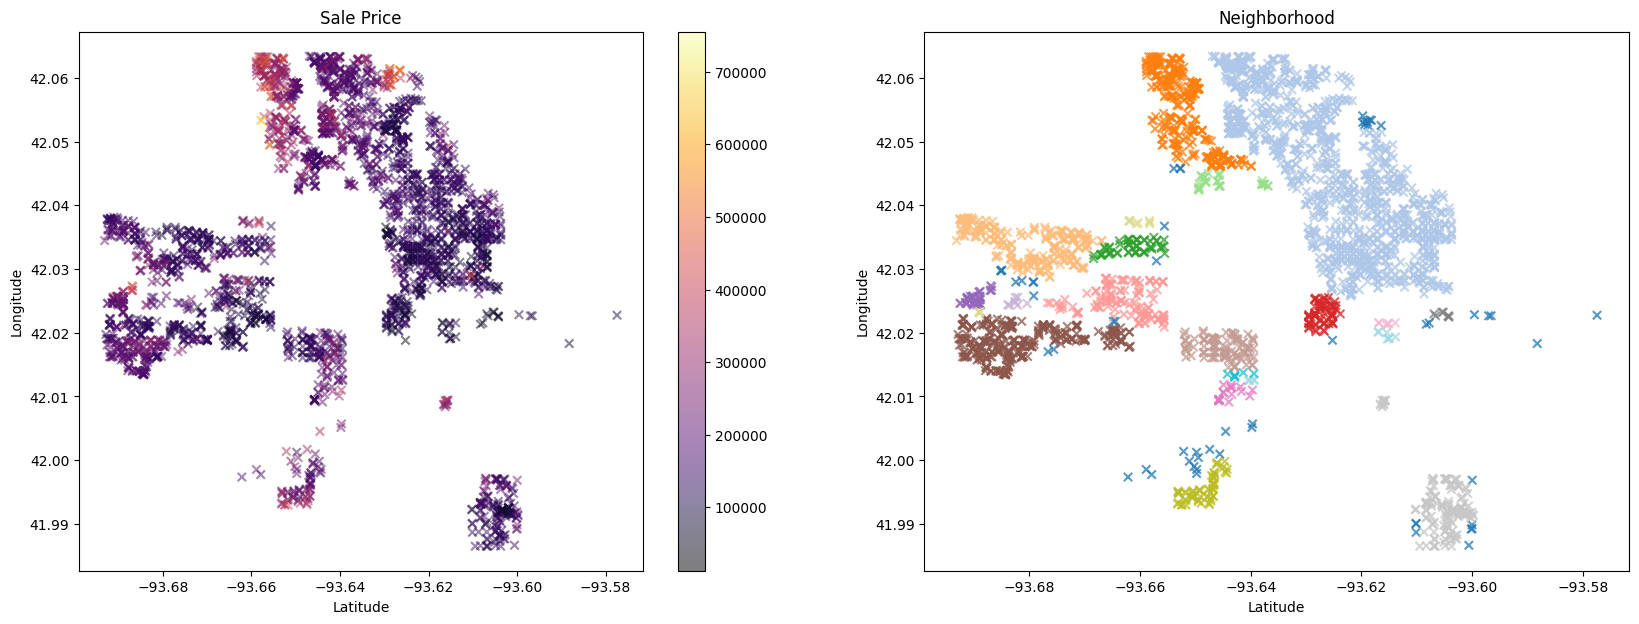

In [9]:
# DBSCAN
from sklearn.cluster import DBSCAN

df_db = df.copy()

dbscan = DBSCAN(eps=0.001, metric='haversine').fit(DataFrame([lat, lon]).T)
df_db['Neighborhood'] = dbscan.labels_

plot_houses(df_db)

##### Analisi dei risultati

Come e' possibile notare dal grafico, DBSCAN non si comporta in modo ottimale sui dati forniti. Esso genera infatti alcuni cluster eccessivamente grandi, che non corrispondono a nessun quartiere, per lo meno in maniera realistica. Inoltre non riesce a catturare tutte le case in un quartiere, lasciandone alcune sparse che non appartengono a nessun cluster.

L'aggiunta delle nuove features e il conseguente allenamento di un modello non sono praticabili con questi risultati.

#### Agglomerative clustering

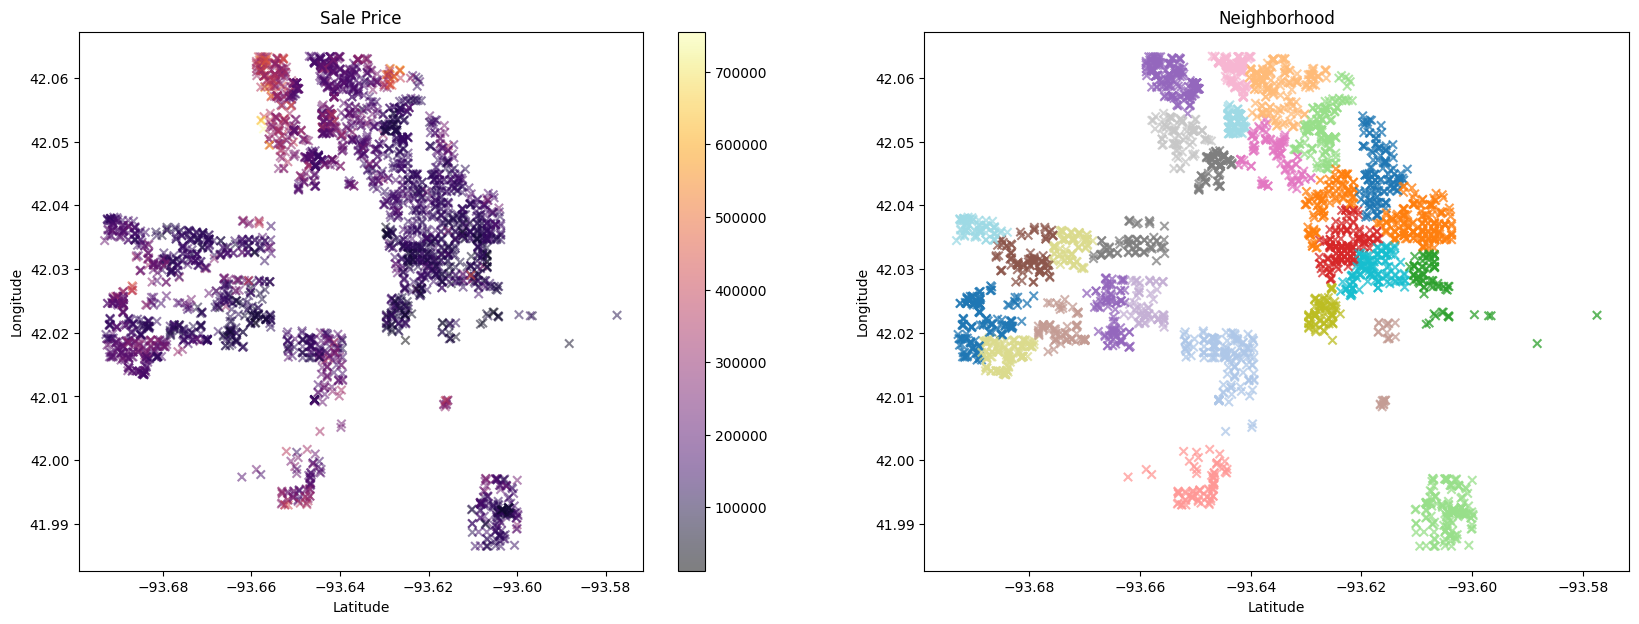

In [10]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

df_ac = df.copy()

ac = AgglomerativeClustering(n_clusters=NEIGHBORHOODS).fit(DataFrame([lat, lon]).T)
df_ac['Neighborhood'] = ac.labels_

plot_houses(df_ac)


In [11]:
# Aggiungiamo la mediana dei prezzi delle case vendute in quel quartiere prima della vendita della nuova casa
df_ac = add_median_price(df_ac)
#Eseguiamo il ridge regressor ma ora con la nuova feature
ac_ev = Evaluator(model, df_ac, 'Sale_Price')

#Valutiamo il modello
ac_ev.evaluate()

r2:                  0.89816
explained_variance:  0.89816
rmse:                0.32181
mae:                 0.15886
max_error:           3.85035

##### Analisi dei risultati
Anche in questo caso si vede una minima perdita di accuracy, osservando i risultati delle metriche $r^2$ e explained variance.

#### Mean shift

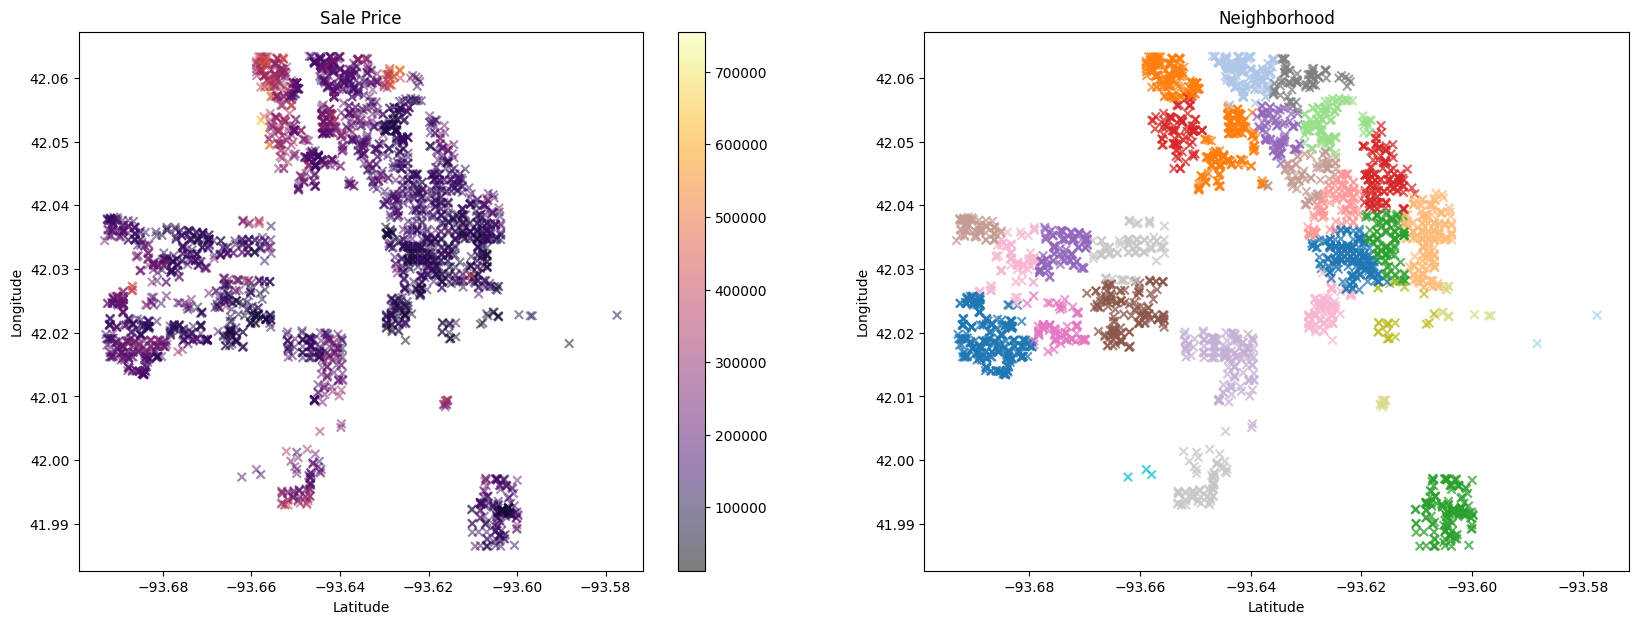

In [12]:
# Mean Shift
from sklearn.cluster import MeanShift

df_ms = df.copy()

# Abbiamo scelto un valore di bandwidth di 0.005 perche' genera un numero di cluster ne scarso, ne ecessivo tramite
# i dati che diamo in input.
ms = MeanShift(bandwidth=0.005).fit(DataFrame([lat, lon]).T)
df_ms['Neighborhood'] = ms.labels_

plot_houses(df_ms)

In [13]:
# Aggiungiamo la mediana dei prezzi delle case vendute in quel quartiere prima della vendita della nuova casa
df_ms = add_median_price(df_ms)
#Eseguiamo il ridge regressor ma ora con la nuova feature
ms_ev = Evaluator(model, df_ms, 'Sale_Price')

#Valutiamo il modello
ms_ev.evaluate()

r2:                  0.89791
explained_variance:  0.89791
rmse:                0.32271
mae:                 0.15801
max_error:           3.83887

##### Analisi dei risultati
Nuovamente si nota una minima perdita di accuratezza rispetto ai dati originali.

#### Affinity propagation

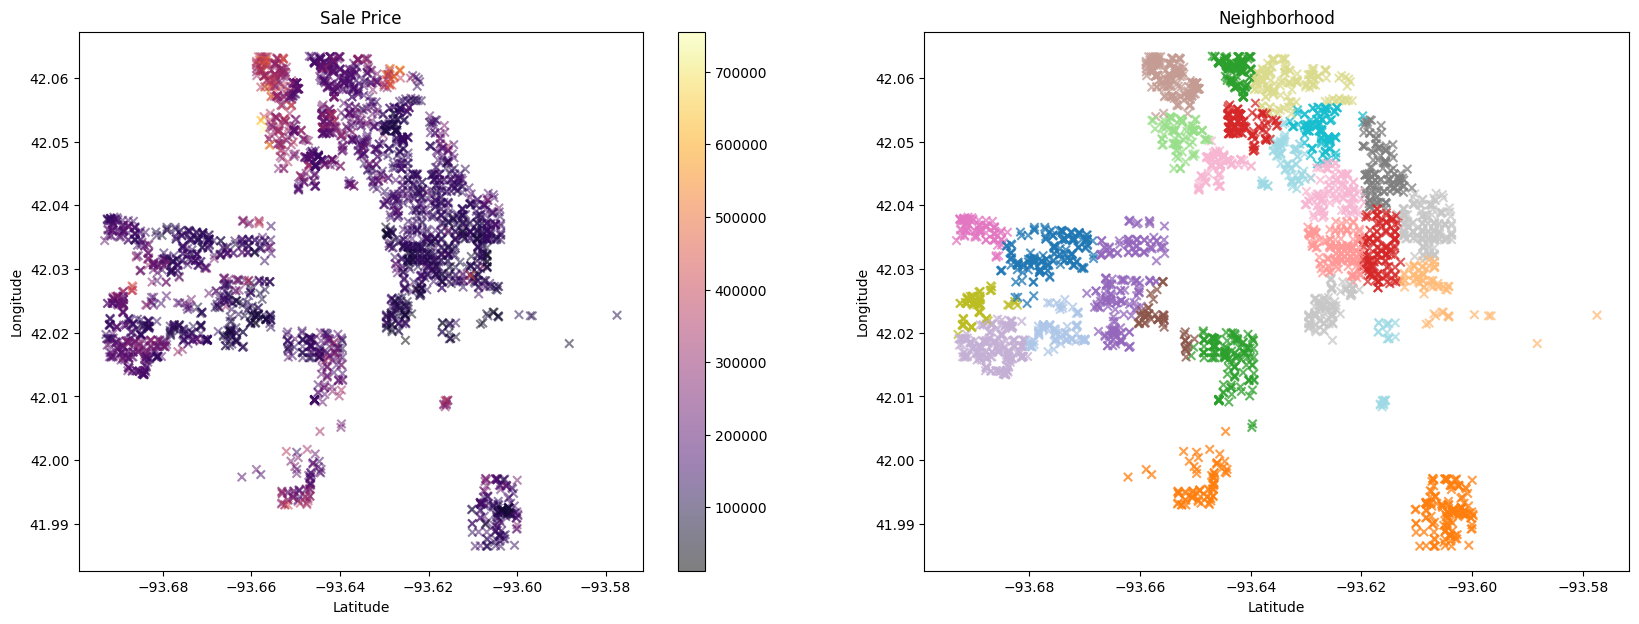

In [14]:
# Affinity Propagation
from sklearn.cluster import AffinityPropagation

df_ap = df.copy()

# Abbiamo scelto un valore di damping di 0.7 perche' genera un numero di cluster ne scarso, ne ecessivo tramite
# i dati che diamo in input.
ap = AffinityPropagation(damping=0.7).fit(DataFrame([lat, lon]).T)
df_ap['Neighborhood'] = ap.labels_

plot_houses(df_ap)

In [15]:
# Aggiungiamo la mediana dei prezzi delle case vendute in quel quartiere prima della vendita della nuova casa
df_ap = add_median_price(df_ap)
#Eseguiamo il ridge regressor ma ora con la nuova feature
ap_ev = Evaluator(model, df_ap, 'Sale_Price')

#Valutiamo il modello
ap_ev.evaluate()

r2:                  0.89840
explained_variance:  0.89842
rmse:                0.32331
mae:                 0.16189
max_error:           3.83656

##### Analisi dei risultati
In questo caso, il metodo appare essere il migliore tra quelli utilizzati. Tuttavia dato che i risultati non sono comunque migliori di quelli ottenuti con i dati originali, non e' possibile utilizzare questi dati per l'allenamento di un modello.

## Conclusioni

Sono stati analizzati diversi risultati ottenuti da diversi metodi di clustering, per lo piu' per sperimentare e capire se fosse possibile ottenere dei dati migliori rispetto al dataset originale. Tuttavia non e' stato notato nessun tipo di miglioramento, bensi' solo una minima riduzione nelle metriche di valutazione, come $r^2$ e explained variance, cosa che non solo rende inefficace il ricalcolo dei quartieri, ma addirittura diminuisce la qualita' del modello finale.

In conclusione, nel dataset finale, usato dai modelli scelti per la predizione dei prezzi delle case, le features sono calcolate direttamente dai quartieri originali e non dai nuovi quartieri ricavati dal clustering.